In [1]:
# This script provides some reporting on the resolver data from identifiers.org
#
# Author: Manuel Bernal Llinares <mbdebian@gmail.com>

In [2]:
import time
import random
import pandas
import requests
import threading
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt
from collections import Counter
from multiprocessing import Pool
from multiprocessing.pool import ThreadPool

%matplotlib inline

In [3]:
# Endpoint from where the information is coming
identifiersorg_resolver_data_url = "https://identifiers.org/rest/collections/expand"
metadata_service_endpoint_from_url = "http://metadata.api.identifiers.org/getMetadataForUrl"

In [4]:
# Initialize pseudo-random number generator
random.seed(time.time())

In [5]:
# Helpers
def make_rest_request_content_type_json(url):
    # TODO - Magic number here!!!
    n_attempts = 42
    response = None
    while n_attempts:
        n_attempts -= 1
        try:
            response = requests.get(url, headers={"Content-Type": "application/json"})
        except Exception as e:
            # Any possible exception counts towards the attempt counter
            # Random wait - TODO - Another magic number!!!
            time.sleep(random.randint(30))
            continue
        if response.ok:
            return response.json()
        # Random wait - TODO - Another magic number!!!
        time.sleep(random.randint(10))
    response.raise_for_status()

In [6]:
def get_metadata_for_url(url):
    """
    This Helper queries the metadata service with a URL, 
    and returns its response back to the caller for further interpretation
    """
    n_attempts = 42
    response = None
    while n_attempts:
        n_attempts -= 1
        try:
            response = requests.post(metadata_service_endpoint_from_url, json={"apiVersion": "1.0", "payload": {"url": url}})
        except Exception as e:
            # Any possible exception counts towards the attempt counter
            # Random wait - TODO - Another magic number!!!
            time.sleep(random.randint(3))
            continue
        if response.ok:
            print("[METADATA][OK] - '{}'".format(url))
            break
        else:
            print("[METADATA][ERROR] - '{}'".format(url))
            break
        # Random wait - TODO - Another magic number!!!
    return response

In [7]:
# Get the resolver data
resolver_dump = make_rest_request_content_type_json(identifiersorg_resolver_data_url)

In [8]:
# Workout how many prefixes there are in identifiers.org
prefixes = set([pid_entry['prefix'] for pid_entry in resolver_dump])

In [9]:
prefixes

{'3dmet',
 'abs',
 'aceview.worm',
 'addgene',
 'adw',
 'affy.probeset',
 'aftol.taxonomy',
 'agricola',
 'allergome',
 'amoebadb',
 'antibodyregistry',
 'antweb',
 'aop',
 'aop.events',
 'aop.relationships',
 'aop.stressor',
 'apd',
 'aphidbase.transcript',
 'apid.interactions',
 'arachnoserver',
 'ardb',
 'ark',
 'arrayexpress',
 'arrayexpress.platform',
 'arraymap',
 'arxiv',
 'asap',
 'ascl',
 'asin',
 'aspgd.locus',
 'aspgd.protein',
 'atc',
 'atcc',
 'atcvet',
 'atfdb.family',
 'autdb',
 'bacdive',
 'bacmap.biog',
 'bacmap.map',
 'bao',
 'bdgp.est',
 'bdgp.insertion',
 'beetlebase',
 'begdb',
 'bgee.family',
 'bgee.gene',
 'bgee.organ',
 'bgee.stage',
 'bigg.compartment',
 'bigg.metabolite',
 'bigg.model',
 'bigg.reaction',
 'bindingdb',
 'biocarta.pathway',
 'biocatalogue.service',
 'biocyc',
 'biogrid',
 'biominder',
 'biomodels.db',
 'biomodels.kisao',
 'biomodels.teddy',
 'biomodels.vocabulary',
 'bionumbers',
 'bioportal',
 'bioproject',
 'biosample',
 'biosystems',
 'biotoo

In [10]:
print("There are #{} Compact ID prefixes registered in identifiers.org".format(len(prefixes)))

There are #665 Compact ID prefixes registered in identifiers.org


In [12]:
# Produce Sample Compact Identifiers list
for pid_entry in resolver_dump:
    prefix = pid_entry['prefix']
    sample_id = pid_entry['resources'][0]['localId']
    print("{}:{}".format(prefix, sample_id))

chebi:36927
ensembl:ENSG00000139618
ec-code:1.1.1.1
uniprot:P0DP23
taxonomy:9606
biomodels.db:BIOMD0000000048
miriam.collection:MIR:00000008
icd:C34
intact:EBI-2307691
interpro:IPR000100
kegg.pathway:hsa00620
kegg.compound:C12345
kegg.reaction:R00100
pubmed:16333295
mim:603903
pirsf:PIRSF000100
reactome:R-HSA-201451
doi:10.1038/nbt1156
pdb:2gc4
go:0006915
sgd:S000003909
sbo:0000262
kegg.drug:D00123
kegg.glycan:G00123
wb:WBGene00000001
pfam:PF01234
insdc:X58356
fb:FBgn0011293
wormpep:CE28239
prosite:PS00001
pubchem.substance:100101
pubchem.compound:100101
arxiv:0807.4956v1
arrayexpress:E-MEXP-1712
mgi:2442292
sabiork.reaction:75
refseq:NP_012345
tcdb:5.A.1.1.1
uniparc:UPI000000000A
mint:MINT-10000
dip:DIP-743N
signaling-gateway:A001094
resid:AA0001
rgd:2018
tair.protein:AASequence:1009107926
tair.gene:Gene:2200934
tair.locus:2200950
hmdb:HMDB00001
lipidmaps:LMPR0102010012
peptideatlas:PAp00000009
geo:GDS1234
eco:0000006
mod:00001
sgd.pathways:PWY3O-214
biogrid:31623
merops:S01.001
panth

In [13]:
# Check the distribution of resources
resource_prefixes = []
for pid_entry in resolver_dump:
    if 'resources' in pid_entry:
        for resource in pid_entry['resources']:
            if 'resourcePrefix' in resource:
                resource_prefixes.append(resource['resourcePrefix'])
            else:
                print("NO RESOURCE PREFIX FOR: PID Entry Name '{}', Resource Information '{}'".format(pid_entry['name'], resource['info']))


NO RESOURCE PREFIX FOR: PID Entry Name 'Ensembl', Resource Information 'Ensembl US West mirror'
NO RESOURCE PREFIX FOR: PID Entry Name 'Ensembl', Resource Information 'Ensembl US East mirror'
NO RESOURCE PREFIX FOR: PID Entry Name 'Ensembl', Resource Information 'Ensembl Asia mirror'
NO RESOURCE PREFIX FOR: PID Entry Name 'Enzyme Nomenclature', Resource Information 'KEGG Ligand Database for Enzyme Nomenclature'
NO RESOURCE PREFIX FOR: PID Entry Name 'UniProt Knowledgebase', Resource Information 'Universal Protein Resource using Persistent URL system'
NO RESOURCE PREFIX FOR: PID Entry Name 'Taxonomy', Resource Information 'Taxonomy through UniProt PURL'
NO RESOURCE PREFIX FOR: PID Entry Name 'Taxonomy', Resource Information 'Bio2RDF'
NO RESOURCE PREFIX FOR: PID Entry Name 'BioModels Database', Resource Information 'Caltech mirror'
NO RESOURCE PREFIX FOR: PID Entry Name 'BioModels Database', Resource Information 'Bio2RDF'
NO RESOURCE PREFIX FOR: PID Entry Name 'ICD', Resource Information

In [14]:
#resource_prefixes

In [15]:
resource_prefixes_distribution = Counter(resource_prefixes)

In [16]:
resource_prefixes_distribution

Counter({'agr': 6,
         'amigo': 2,
         'bioentitylink': 5,
         'bptl': 35,
         'cpmc': 1,
         'ebi': 58,
         'enzymeportal': 1,
         'epmc': 2,
         'expasy': 2,
         'expenz': 1,
         'hubmed': 1,
         'intenz': 1,
         'ncbi': 33,
         'ols': 41,
         'omicsdi': 12,
         'pdbe': 1,
         'pdbj': 1,
         'quickgo': 2,
         'rcsb': 3,
         'sib': 1})

In [17]:
print("There #{} Resource Selectors in identifiers.org".format(len(resource_prefixes_distribution.keys())))

There #20 Resource Selectors in identifiers.org


In [18]:
labels = sorted(resource_prefixes_distribution.keys())
values = [resource_prefixes_distribution.get(key) for key in labels]

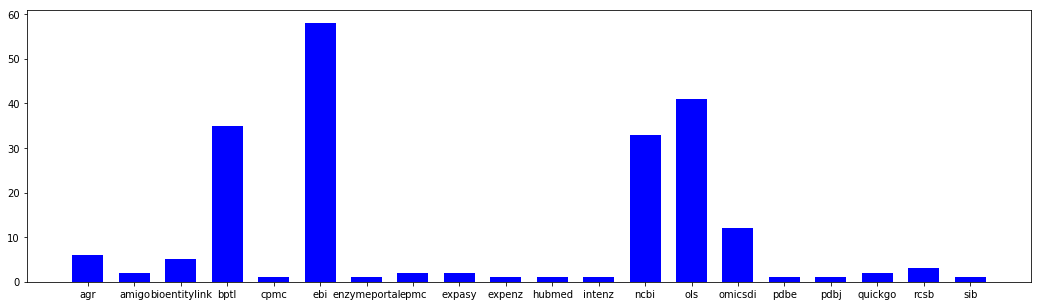

In [19]:
# I don't like this Pie Chart
fig1, ax1 = plt.subplots()
fig1.set_size_inches(18, 5)
ax1.bar(labels, values, 1/1.5, color="blue")
#ax1.pie(values, labels=labels, shadow=True, startangle=90)
#ax1.axis('equal')
plt.show()

In [20]:
# Create a report on metadata
columns = ['PidEntryName',
           'PidEntryPrefix',
           'PidEntryUrl', 
           'ResourceInfo', 
           'ResourceInstitution', 
           'ResourceLocation', 
           'ResourceOfficial', 
           'ResourcePrefix', 
           'ResourceLocalId', 
           'WasMetadataFound', 
           'MetadataContent', 
           'ResourceTestUrl', 
           'MetadataServiceResponseStatus', 
           'MetadataServiceResponseError']
metadata_report = pandas.DataFrame(columns=columns)

In [21]:
# Prepare the URLs and initial report (I could have done everything in one pass, but this is just investigating the dataset)
for pid_entry in resolver_dump:
    entry = pandas.Series(['---'] * len(columns), index=columns)
    entry.PidEntryName = pid_entry['name']
    entry.PidEntryPrefix = pid_entry['prefix']
    entry.PidEntryUrl = pid_entry['url']
    if ('resources' not in pid_entry) or (not pid_entry['resources']):
        metadata_report = metadata_report.append(entry, ignore_index=True)
    for resource in pid_entry['resources']:
        resource_entry = entry.copy()
        resource_entry.ResourceInfo = resource['info']
        resource_entry.ResourceInstitution = resource.get('institution', '---')
        resource_entry.ResourceLocation = resource.get('location', '---')
        resource_entry.ResourceOfficial = resource.get('official', '---')
        resource_entry.ResourcePrefix = resource.get('resourcePrefix', '---')
        resource_entry.ResourceLocalId = resource.get('localId', '---')
        resource_entry.WasMetadataFound = 'No'
        resource_entry.ResourceTestUrl = None
        if ('accessURL' in resource) and ('localId' in resource):
            resource_entry.ResourceTestUrl = resource['accessURL'].replace('{$id}', resource['localId'])
        metadata_report = metadata_report.append(resource_entry, ignore_index=True)        

In [22]:
metadata_report.ResourceTestUrl.describe()

count                                             822
unique                                            821
top       https://www.ncbi.nlm.nih.gov/nuccore/X58356
freq                                                2
Name: ResourceTestUrl, dtype: object

In [23]:
metadata_report.head()

,PidEntryName,PidEntryPrefix,PidEntryUrl,ResourceInfo,ResourceInstitution,ResourceLocation,ResourceOfficial,ResourcePrefix,ResourceLocalId,WasMetadataFound,MetadataContent,ResourceTestUrl,MetadataServiceResponseStatus,MetadataServiceResponseError
0,ChEBI,chebi,http://identifiers.org/chebi,ChEBI (Chemical Entities of Biological Interest),"European Bioinformatics Institute, Hinxton, Ca...",UK,True,ebi,36927,No,---,https://www.ebi.ac.uk/chebi/searchId.do?chebiI...,---,---
1,ChEBI,chebi,http://identifiers.org/chebi,ChEBI through OLS,"European Bioinformatics Institute, Hinxton, Ca...",UK,False,ols,36927,No,---,https://www.ebi.ac.uk/ols/ontologies/chebi/ter...,---,---
2,ChEBI,chebi,http://identifiers.org/chebi,ChEBI through BioPortal,"National Center for Biomedical Ontology, Stanford",USA,False,bptl,36927,No,---,http://purl.bioontology.org/ontology/CHEBI/CHE...,---,---
3,Ensembl,ensembl,http://identifiers.org/ensembl,Ensembl at Sanger/EMBL-EBI,Sanger Institute and European Bioinformatics I...,UK,True,ebi,ENSG00000139618,No,---,https://www.ensembl.org/id/ENSG00000139618,---,---
4,Ensembl,ensembl,http://identifiers.org/ensembl,Ensembl US West mirror,---,USA,False,---,ENSG00000139618,No,---,http://uswest.ensembl.org/id/ENSG00000139618,---,---


In [24]:
# Parallel call to metadata service, this is a lot slower, good enough as proof of concept
#metadata_requests = {index: threading.Thread(target=get_metadata_for_url(metadata_report.loc[index].ResourceTestUrl)) for index in range(metadata_report.shape[0]) if metadata_report.loc[index].ResourceTestUrl}

# Parallel wrapper - Version using multiprocessing, it crashes within Jupyter
#def metadata_request_parallel_wrapper(context, url):
#    context.put(get_metadata_for_url(url))
#metadata_requests = {index: multiprocessing.Process(target=metadata_request_parallel_wrapper, args=(multiprocessing.Queue(), metadata_report.loc[index].ResourceTestUrl),) for index in range(metadata_report.shape[0]) if metadata_report.loc[index].ResourceTestUrl}
#metadata_requests = {index: multiprocessing.Process(target=get_metadata_for_url, args=(metadata_report.loc[index].ResourceTestUrl,)) for index in range(metadata_report.shape[0]) if metadata_report.loc[index].ResourceTestUrl}
#[process.start() for process in metadata_requests.values()]

# Another approach, with Thread Pool
pool = Pool(processes=mp.cpu_count())
indexes_to_process = [index for index in range(metadata_report.shape[0]) if metadata_report.loc[index].ResourceTestUrl]

In [ ]:
metadata_requests = pool.map(get_metadata_for_url, metadata_report.ResourceTestUrl[indexes_to_process])

In [ ]:
for (index, response) in zip(indexes_to_process, metadata_requests):
    if response.ok:
        metadata_report.loc[index].WasMetadataFound = 'Yes'
        metadata_report.loc[index].MetadataContent = response.json()['payload']['metadata']
        print("[METADATA][OK] - '{}'".format(metadata_report.loc[index].ResourceTestUrl))
    else:
        print("[METADATA][ERROR] - '{}'".format(metadata_report.loc[index].ResourceTestUrl))
    if 'errorMessage' in response.json():
        metadata_report.loc[index].MetadataServiceResponseError = response.json()['errorMessage']
    else:
        metadata_report.loc[index].MetadataServiceResponseError = "METADATA SERVICE ERROR"
        print("[METADATA][QUERY_ERROR] - '{}', response '{}'".format(metadata_report.loc[index].ResourceTestUrl, response.json()))
    metadata_report.loc[index].MetadataServiceResponseStatus = response.status_code

In [ ]:
metadata_report.head()

In [ ]:
# Dump report to file
metadata_report.to_csv('metadata_report.csv', encoding='utf-8')